In [13]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [14]:
from matmul import linear_estimates, logit_estimates, attend_estimates
from norm import layer_norm_estimates
from pointwise import softmax_estimates, dropout_estimates, nonlinear_act_estimates
from time_projections import get_time_flops, get_time_mem, get_time_comm, get_topology, get_total_time

In [15]:
def compute_timings_and_stats(summary, system):
    ''' timings, any other df stats '''

    # which layers use tensor cores
    tensor_core_layers = ['fc1', 'fc2', 'qkv_proj', 'v_proj', 'logits', 'attend']
   
    # time for forward
    summary['t_comp_fwd'] = summary.apply(lambda x: get_time_flops(x["flops_fwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_fwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_fwd"], system=system), axis=1)
    # time for backward
    summary['t_comp_bwd'] = summary.apply(lambda x: get_time_flops(x["flops_bwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_bwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_bwd"], system=system), axis=1)
    
    # times
    summary['intensity'] = summary['t_comp_fwd'] / summary['t_mem_fwd']
    # roofline
    summary['t_fwd'] = summary.apply(lambda x: max(x['t_comp_fwd'], x['t_mem_fwd']), axis=1)
    summary['t_bwd'] = summary.apply(lambda x: max(x['t_comp_bwd'], x['t_mem_bwd']), axis=1)
    
    # time for communication
    use_empirical = False
    summary['comm_topology'] = summary.apply(lambda x: get_topology(x["comm_size"], system=system), axis=1)
    summary['t_comm_fwd'] = summary.apply(lambda x: get_time_comm(x["comm_fwd"],
                                                                  n_gpus=x["comm_size"],
                                                                  comm_type=x["comm_fwd_type"], 
                                                                  topology=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    summary['t_comm_bwd'] = summary.apply(lambda x: get_time_comm(x["comm_bwd"],
                                                                  n_gpus=x["comm_size"],
                                                                  comm_type=x["comm_bwd_type"], 
                                                                  topology=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    
    # total time
    summary['t_total_fwd'] = summary.apply(lambda x: get_total_time(x['t_fwd'], x['t_comm_fwd'], use_max=False), axis=1)
    summary['t_total_bwd'] = summary.apply(lambda x: get_total_time(x['t_bwd'], x['t_comm_bwd'], use_max=False), axis=1)
    
    # fraction
    summary['frac_t_comm_fwd'] = summary['t_comm_fwd'] / summary['t_total_fwd']
    summary['frac_t_comm_bwd'] = summary['t_comm_bwd'] / summary['t_total_bwd']
    
    # memory per computing unit
    summary['total_mem_fwd'] = summary.apply(lambda x: x["total_mem_fwd"], axis=1)
    summary['total_mem_bwd'] = summary.apply(lambda x: x["total_mem_bwd"], axis=1)

    return summary

In [16]:
#### nn modules ###
def MLP_estimates(b, l, e, f, depth, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, 
                  parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    MLP layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim
                f: hidden dim
                element_size: in MB
                mask_element_size: in MB (for dropout)
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        forward pass: 
             X = XW + b
             (b,l,f) = (b,l,e) * (e,f) + (1,f)
             X = nonlinear(X)
             (b,l,f) = (b,l,f)
             X = dropout(X)
             (b,l,f) = (b,l,f) * (b,l,f) [random mask]
             X = linear(X)
             (b,l,e) = (b,l,f) * (f,e) + (1,e)
             X = dropout(X)
             (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
        backward pass:
             chain rule
             
    parallelism:
            X = XW + b
            (b,l/m2,f/m1) = (b,l/m2,e/m1) * (e/m1,f/m1) + (1,f/m1)
            X = nonlinear(X)
            (b,l/m2,f/m1) = (b,l/m2,f/m1)
            X = dropout(X)
            (b,l/m2,f/m1) = (b,l/m2,f/m1) * (b,l/m2,f/m1) [random mask]
            X = linear(X)
            (b,l/m2,e/m1) = (b,l/m2,f/m1) * (f/m1,e/m1) + (1,e/m1)
            X = dropout(X)
            (b,l/m2,e/m1) = (b,l/m2,e/m1) * (b,l/m2,e/m1) [random mask]
            
    comments: 
    """
    
    summary = []
    
    flops_per_add = 1 * flops_units
    
    m1 = parallelism['m1']
    m2 = parallelism['m2'] 
    
    m1_parallel = (m1 > 1)
    m2_parallel = (m2 > 1)
    
    total_time = 0
    
    ######################################################################################################################################################
    ######################################################################################################################################################
        
    stats = linear_estimates(b, l // m2, e // m1, f // m1, element_size=element_size, 
                             has_bias=True, flops_units=flops_units)
    stats["layer"] = "fc1"   
    # sync/comm layers
    stats["comm_bwd"] = (m1+m2)/(m1*m2) * (b * l * f) * element_size # bwd comms for partial sums of b,l,e
    stats["comm_bwd_type"] = "broadcast+reduce" 
    stats["comm_size"] = m1*m2
    #TODO add extra comps for reduce
    stats["flops_bwd"] += m1/(m1*m2) * (b * l * f) * flops_per_add
    
    stats["comm_fwd"] = (m1+m2)/(m1*m2) * (b * l * e) * element_size # bwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "broadcast" 
    stats["comm_size"] = m1*m2
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = nonlinear_act_estimates(b, l // m2, f // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "act"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, f // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr1"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l // m2, f // m1, e // m1, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "fc2"
    # sync/comm layers
    stats["comm_fwd"] = (m1+m2)/(m1*m2) * (b * l * f) * element_size # fwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    
    stats["comm_bwd"] = (m1+m2)/(m1*m2) * (b * l * e) * element_size
    stats["comm_bwd_type"] = "broadcast+reduce"
    stats["comm_size"] = m1
    #TODO add extra compute for reduce
    stats["flops_bwd"] += m1/(m1*m2) * (b * l * e) * flops_per_add
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, e // m1, element_size=element_size, mask_element_size=mask_element_size, 
                              flops_units=flops_units)
    stats["layer"] = "dpr2"
    # sync/comm layers
    
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)
    
    return summary
        

In [17]:
def self_attention_estimates(b, l, e, h, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, 
                             parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    dropout layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim/hidden dim
                h: number of attention heads
                element_size: in MB
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        define: q = e/h
        forward pass: 
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h,q,3) = (b,l,e) * (e,3hq)
             A = QK'/sqrt(q)
             (b,h,l,l) = (b,h,l,q) * (b,h,q,l)
             A = softmax(A)
             (b,h,l,l) = (b,h,l,l)
             A = dpr(A)
             Y = AV
             (b,h,l,q) = (b,h,l,l) * (b,h,l,q)
             Y = VW
             (b,l,e) = (b,l,hq) * (hq,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
             
        backward pass:
             chain rule
             
        parallelism:
             X = norm(X)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
             Q = XW, K = XW, V = XW
             (b,l/m2,h,q/m1,3) = (b,l/m2,e/m1) * (e,3hq/m1)
             A = QK'/sqrt(q)
             (b,h/m1,l/m2,l/m2) = (b,h/m1,l/m2,q) * (b,h/m1,q,l/m2)
             A = softmax(A)
             (b,h/m1,l/m2,l/m2) = (b,h/m1,l/m2,l/m2)
             A = dpr(A)
             (b,h/m1,l/m2,l/m2) = (b,h/m1,l/m2,l/m2)
             Y = AV
             (b,h/m1,l/m2,q) = (b,h/m1,l/m2,l/m2) * (b,h/m1,l/m2,q)
             Y = VW
             (b,l/m2,e/m1) = (b,l/m2,hq/m1) * (hq/m1,e/m1)
             Y = dpr(Y)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
             Y = norm(Y)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
            
    
    comments: 
    """
    summary = []
    
    flops_per_add = 1 * flops_units
    
    q = e // h
    
    m1 = parallelism['m1']
    m2 = parallelism['m2'] 
    
    m1_parallel = (m1 > 1)
    m2_parallel = (m2 > 1)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m2, e // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_1"
    # sync/comm layers
    #TODO add layer norm comms and comps
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    #SUMMA
    stats = linear_estimates(b, l // m2, e // m1, (3*e) // m1, element_size=element_size, has_bias=False, flops_units=flops_units)
    stats["layer"] = "qkv_proj"
    # sync/comm layers
    stats["comm_bwd"] = (m1+m2)/(m1*m2) * (b * l * 3*e) * element_size # reduce scatter before going to ln: TODO check?
    stats["comm_bwd_type"] = "broadcast+reduce"
    stats["comm_size"] = m1*m2
    #TODO add extra comps for reduce
    stats["flops_bwd"] += m1/(m1*m2) * (b * l * 3*e) * flops_per_add
    
    stats["comm_fwd"] = (m1+m2)/(m1*m2) * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = logit_estimates(b, l // m2, q, h // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "logits"
    summary.append(stats)
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = softmax_estimates(b, l // m2, h // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "softmax"
    #coms for distributed softmax
    stats["comm_fwd"] = (m1*m2) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    
    stats["comm_bwd"] = (m1*m2) * element_size # all gather for the next op
    stats["comm_bwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, (h*l) // (m1*m2), element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout_softmax"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################

    # SUMMA
    stats = attend_estimates(b, l // m2, q, h // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "attend"
    # sync/comm layers
    stats["comm_bwd"] = (m1+m2)/(m1*m2) * (b * l * h) * element_size # reduce scatter before going to ln: TODO check?
    stats["comm_bwd_type"] = "broadcast+reduce"
    stats["comm_size"] = m1*m2
    #TODO add extra comps for reduce
    stats["flops_bwd"] += m1/(m1*m2) * (b * l * h) * flops_per_add
    
    stats["comm_fwd"] = (m1+m2)/(m1*m2) * (b * l * l) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    #SUMMA
    stats = linear_estimates(b, l // m2, (h*q) // m1, e //m1, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "v_proj"
    # sync/comm layers
    # sync/comm layers
    stats["comm_bwd"] = (m1+m2)/(m1*m2) * (b * l * e) * element_size # reduce scatter before going to ln: TODO check?
    stats["comm_bwd_type"] = "broadcast+reduce"
    stats["comm_size"] = m1*m2
    #TODO add extra comps for reduce
    stats["flops_bwd"] += m1/(m1*m2) * (b * l * e) * flops_per_add
    
    stats["comm_fwd"] = (m1+m2)/(m1*m2) * (b * l *  h * q) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, e // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout"
    # sync/comm layers
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m2, e // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_2"
    # comm for layer norm
    stats["comm_fwd"] = (m1*m2) * element_size 
    stats["comm_fwd_type"] = "broadcast"
    stats["comm_size"] = m1*m2
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)

    
    return summary

In [6]:
# ### model
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# b = 1
# patch = 16
# ih = 720
# iw = 1440 
# l = 2048 #ih // patch * iw // patch
# e = 12288
# f = 4 * e
# h = 96
# depth = 96
# fp32_sz = 4E-9
# fp16_sz = 2E-9
# int_sz = 1E-9
# flops_units = 1E-12 # teraflops

# print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

# ### model parallelism
# parallelism = {'m1': 4,
#                'm2': 2}
# ### system configs
# system = {'matrix_flops_fp16': 312,
#           'vector_flops_fp32': 19.5,
#           'vector_flops_fp16': 78,
#           'hbm_bandwidth': 1555,
#           'nvlink_bandwidth': 600,
#           'ib_bandwidth': 100,
#           'hbm_latency': 0,
#           'nvlink_latency': 0,
#           'ib_latency': 0,
#           'nvlink_size': 0}
# print("parallelization: m1 = {}, m2 = {}".format(parallelism['m1'], parallelism['m2']))

# # MLP
# df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
#                        parallelism=parallelism, system=system)
# cols = df_mlp.columns.tolist()
# cols.remove('layer')
# cols = ['layer'] + cols

# # self attention
# df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
#                                  parallelism=parallelism, system=system)

# # sum these columns (mem in buffer: activation buffers, weights, weights_grads, total flops, timings)
# layer_track_cols = ['activation_buffer', 'weights_mem', 
#                     'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
#                     't_total_fwd', 't_total_bwd', 't_comm_fwd', 't_comm_bwd']

# print('\n************** MLP layer estimates **************\n')
# display(df_mlp[cols])
# display(df_mlp[layer_track_cols].sum() * depth)
# t_f = df_mlp['t_total_fwd'].sum()
# t_c = df_mlp['t_comm_fwd'].sum()
# print('time spend in comms = {}'.format(t_c / t_f))

# print('\n************** SA layer estimates **************\n')
# display(df_sa[cols])
# display(df_sa[layer_track_cols].sum() * depth)
# t_f = df_sa['t_total_fwd'].sum()
# t_c = df_sa['t_comm_fwd'].sum()
# print('time spend in comms = {}'.format(t_c / t_f))

In [18]:
def plot(n_gpus, parallelism, model, system, axs, lgnd=['MLP', 'SA'], lfmt="-"):
    
    b = model['b']
    l = model['l']
    e = model['e']
    f = model['f']
    depth=model['depth']
    h = model['h']
    element_size = model['element_size'] #fp16
    mask_element = model['mask_element'] # int
    flops_units = model['flops_units']
    fp16_sz = model['fp16_sz']
    int_sz = model['int_sz']
    
    t_frac_mlp = []
    t_frac_sa = []

    t_mlp_c = []
    t_sa_c = []

    t_mlp_comm = []
    t_sa_comm = []

    for n in n_gpus:
        parallelism['m1'] = int(np.sqrt(n))
        parallelism['m2'] = int(np.sqrt(n))

        df_mlp = MLP_estimates(b, l, e, f, depth, element_size=element_size, mask_element_size=mask_element, 
                               flops_units=flops_units, 
                               parallelism=parallelism, system=system)
        df_sa = self_attention_estimates(b, l, e, h, element_size=element_size, mask_element_size=mask_element, 
                                     flops_units=flops_units, 
                                     parallelism=parallelism, system=system)
        t_f = df_mlp['t_total_fwd'].sum()
        t_c = df_mlp['t_comm_fwd'].sum()
        t_mlp_c.append(t_f)
        t_mlp_comm.append(t_c)
        t_frac_mlp.append(t_c / t_f)

        t_f = df_sa['t_total_fwd'].sum()
        t_c = df_sa['t_comm_fwd'].sum()
        t_sa_c.append(t_f)
        t_sa_comm.append(t_c)
        t_frac_sa.append(t_c / t_f)


    ax = axs[0]
    ax.plot(n_gpus, t_frac_mlp, lfmt, linewidth=2, c=c1, marker='.')
    ax.plot(n_gpus, t_frac_sa, lfmt, linewidth=2, c=c2, marker='.')
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.legend(lgnd, fontsize=fsz-4)
    # ax.set_xscale('log')
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Fraction of time in comms', fontsize=fsz)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=fsz-4)

    ax = axs[1]
    ax.plot(n_gpus, t_mlp_c, lfmt, linewidth=2, c=c1, marker='.')
    ax.plot(n_gpus, t_sa_c, lfmt, linewidth=2, c=c2, marker='.')
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(lgnd, fontsize=fsz-4)

/var/folders/qr/gqm1f6cd55x82rfy3bm94ql400233k/T/ipykernel_47426/3980924849.py:48: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(n_gpus, t_frac_mlp, lfmt, linewidth=2, c=c1, marker='.')
/var/folders/qr/gqm1f6cd55x82rfy3bm94ql400233k/T/ipykernel_47426/3980924849.py:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(n_gpus, t_frac_sa, lfmt, linewidth=2, c=c2, marker='.')
/var/folders/qr/gqm1f6cd55x82rfy3bm94ql400233k/T/ipykernel_47426/3980924849.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(n_gpus, t_mlp_c, lfmt, linewidth=2, c=c1, marker='.')
/var/folders/qr/gqm1f6cd55x82rfy3bm94ql400233k/T/ipykernel_47426/398092484

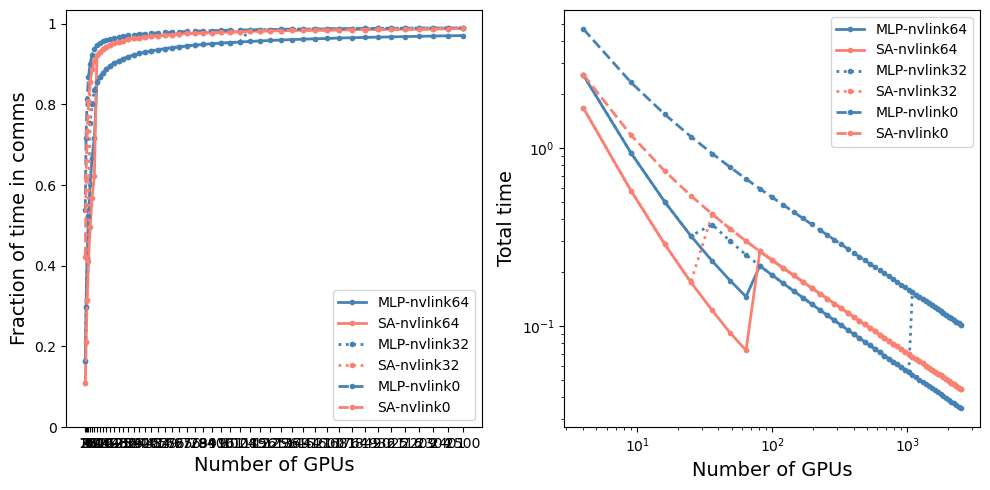

In [19]:
# Sweeps
### model parallelism
n_gpus = [x**2 for x in range(2,51)]
parallelism = {'m1': 1,
               'm2': 1}
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 600,
          'ib_bandwidth': 100,
          'nvlink_size': 8,
          'nvlink_latency': 0,
          'ib_latency': 0}

model = {'b': 1, 
         'l': 2048,
         'e': 12288,
         'f': 4 * 12288,
         'h': 96,
         'depth': 96,
         'element_size': 2E-9,
         'mask_element': 1E-9,
         'fp32_sz': 4E-9,
         'fp16_sz':  2E-9,
         'int_sz': 1E-9,
         'flops_units': 1E-12}

fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 14

nvs = 64
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
plot(n_gpus, parallelism, model, system, axs, lgnd=lgnd, lfmt="o-")
nvs = 32
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
plot(n_gpus, parallelism, model, system, axs, lgnd=lgnd, lfmt="*:")
system['nvlink_size'] = 0
lgnd += ["MLP-nvlink0", "SA-nvlink0"]
plot(n_gpus, parallelism, model, system, axs, lgnd=lgnd, lfmt="o--")

In [12]:
50**2

2500